# Discrete stochastic Erlang SEIR model

Author: Lam Ha @lamhm

Date: 2018-10-03

## Calculate Discrete Erlang Probabilities

The following function is to calculate the discrete truncated Erlang probability, given $k$ and $\gamma$:

\begin{equation*}
p_i =
\frac{1}{C(n^{E})}
\Bigl(\sum_{j=0}^{k-1}
    \frac{e^{-(i-1)\gamma} \times ((i-1)\gamma)^{j}} {j!}
-\sum_{j=0}^{k-1}
    \frac{e^{-i\gamma} \times (i\gamma)^{j}} {j!}\Bigr),\quad\text{for $i=1,...,n^{E}$}.
\end{equation*}

where

\begin{equation*}
n^{E} = argmin_n\Bigl(C(n) = 1 - \sum_{j=0}^{k-1}
    \frac{e^{-n\gamma} \times (n\gamma)^{j}} {j!} > 0.99 \Bigr)
\end{equation*}

**N.B. The formula of $p_i$ here is slightly different from what is shown in the original paper because the latter (which is likely to be wrong) would lead to negative probabilities.**

In [1]:
#' @param k     The shape parameter of the Erlang distribution.
#' @param gamma The rate parameter of the Erlang distribution.
#' @return      A vector containing all p_i values, for i = 1 : n.
compute_erlang_discrete_prob <- function(k, gamma) {
    n_bin <- 0
    factorials <- 1    ## 0! = 1
    for (i in 1 : k) {
        factorials[i + 1] <- factorials[i] * i    ## factorial[i + 1] = i!
    }

    one_sub_cummulative_probs <- NULL
    cummulative_prob <- 0
    while (cummulative_prob <= 0.99) {
        n_bin <- n_bin + 1

        one_sub_cummulative_probs[n_bin] <- 0
        for ( j in 0 : (k - 1) ) {
            one_sub_cummulative_probs[n_bin] <-
                one_sub_cummulative_probs[n_bin]  +
                (
                    exp( -n_bin * gamma )
                    * ( (n_bin * gamma) ^ j )
                    / factorials[j + 1]    ## factorials[j + 1] = j!
                )
        }
        cummulative_prob <- 1 - one_sub_cummulative_probs[n_bin]
    }
    one_sub_cummulative_probs <- c(1, one_sub_cummulative_probs)

    density_prob <-
        head(one_sub_cummulative_probs, -1) - tail(one_sub_cummulative_probs, -1)
    density_prob <- density_prob / cummulative_prob

    return(density_prob)
}

The implementation above calculates discrete probabilities $p_i$'s base on the cummulative density function of the Erlang distribution:

\begin{equation*}
p_i = CDF_{Erlang}(x = i) - CDF_{Erlang}(x = i-1)
\end{equation*}

Meanwhile, the estimates of $p_i$'s in the original paper seems to be based on the probability density function:

\begin{equation*}
p_i = PDF_{Erlang}(x = i)
\end{equation*}

While the two methods give slightly different estimates, they do not lead to any visible differences in the results of the subsequent simulations. This implementation uses the CDF function since it leads to faster runs.

## Simulate the SEIR Dynamics

The next function is to simulate the SEIR (susceptible, exposed, infectious, recovered) dynamics of an epidemic, assuming that transmission is frequency-dependent, i.e.

\begin{equation*}
\beta = \beta_0 \frac{I(t)}{N}
\end{equation*}

where $N$ is the population size, $I(t)$ is the number of infectious people at time $t$, and $\beta_0$ is the base transmission rate.

This model does not consider births and deads (i.e. $N$ is constant).

The rates at which individuals move through the E and the I classes are assumed to follow Erlang distributions of given shapes ($k^E$, $k^I$) and rates ($\gamma^E$, $\gamma^I$).

In [26]:
#' @param initial_state A vector that contains 4 numbers corresponding to the
#'                      initial values of the 4 classes: S, E, I, and R.
#' @param parameters    A vector that contains 5 numbers corresponding to the
#'                      following parameters: the shape and the rate parameters
#'                      of the Erlang distribution that will be used to
#'                      calculate the transition rates between the E components
#'                      (i.e. k[E] and gamma[E]), the shape and the rate parameters
#'                      of the Erlang distribution that will be used to
#'                      calculate the transition rates between the I components
#'                      (i.e. k[I] and gamma[I]), and the base transmission rate
#'                      (i.e. beta).
#' @param max_time      The length of the simulation.
#' @return A data frame containing the values of S, E, I, and R over time
#'         (from 1 to max_time).
seir_simulation <- function(initial_state, parameters, max_time) {
    names(initial_state) <- c("S", "E", "I", "R")
    names(parameters) <- c( "erlang_shape_for_E", "erlang_rate_for_E",
                            "erlang_shape_for_I", "erlang_rate_for_I",
                            "base_transmission_rate" )

    population_size <- sum(initial_state)
    sim_data <- data.frame( time = c(1 : max_time),
                            S = NA, E = NA, I = NA, R = NA )
    sim_data[1, 2:5] <- initial_state

    ## Initialise a matrix to store the states of the exposed sub-blocks over time.
    exposed_block_adm_rates <- compute_erlang_discrete_prob(
        k = parameters["erlang_shape_for_E"],
        gamma = parameters["erlang_rate_for_E"]
    )
    n_exposed_blocks <- length(exposed_block_adm_rates)
    exposed_blocks <- matrix( data = 0, nrow = max_time,
                              ncol = n_exposed_blocks )
    exposed_blocks[1, n_exposed_blocks] <- sim_data$E[1]

    ## Initialise a matrix to store the states of the infectious sub-blocks over time.
    infectious_block_adm_rates <- compute_erlang_discrete_prob(
        k = parameters["erlang_shape_for_I"],
        gamma = parameters["erlang_rate_for_I"]
    )
    n_infectious_blocks <- length(infectious_block_adm_rates)
    infectious_blocks <- matrix( data = 0, nrow = max_time,
                                 ncol = n_infectious_blocks )
    infectious_blocks[1, n_infectious_blocks] <- sim_data$I[1]

    ## Run the simulation from time t = 2 to t = max_time
    for (time in 2 : max_time) {
        transmission_rate <-
            parameters["base_transmission_rate"] * sim_data$I[time - 1] /
            population_size
        exposure_prob <- 1 - exp(-transmission_rate)

        new_exposed <- rbinom(1, sim_data$S[time - 1], exposure_prob)
        new_infectious <- exposed_blocks[time - 1, 1]
        new_recovered  <- infectious_blocks[time - 1, 1]
        
        if (new_exposed > 0) {
            exposed_blocks[time, ] <- t(
                rmultinom(1, size = new_exposed,
                          prob = exposed_block_adm_rates)
            )
        }
        exposed_blocks[time, ] <-
            exposed_blocks[time, ] +
            c( exposed_blocks[time - 1, 2 : n_exposed_blocks], 0 )

        if (new_infectious > 0) {
            infectious_blocks[time, ] <- t(
                rmultinom(1, size = new_infectious,
                          prob = infectious_block_adm_rates)
            )
        }
        infectious_blocks[time, ] <-
            infectious_blocks[time, ] +
            c( infectious_blocks[time - 1, 2 : n_infectious_blocks], 0 )

        sim_data$S[time] <- sim_data$S[time - 1] - new_exposed
        sim_data$E[time] <- sum(exposed_blocks[time, ])
        sim_data$I[time] <- sum(infectious_blocks[time, ])
        sim_data$R[time] <- sim_data$R[time - 1] + new_recovered
    }

    return(sim_data)
}

To run a simulation, simply call the $seir\_simulation(\dots)$ method above.

Below is an example simulation where $k^E = 5$, $\gamma^E = 1$, $k^I = 10$, $\gamma^I = 1$, and $\beta_0 = 0.25$ ($R_0 = \beta_0\frac{k^I}{\gamma^I} = 2.5$). The population size is $N = 10,000$. The simmulation starts with 1 exposed case and everyone else belongs to the susceptible class. These settings are the same the the simulation 11 of the original paper.

**N.B. Since this is a stochastic model, there is chance for the outbreak not to occur even with a high $R_0$.**

In [27]:
sim <- seir_simulation( initial_state = c(S = 9999, E = 1, I = 0, R = 0),
                        parameters = c(5, 1, 10, 1, 0.25),
                        max_time = 300 )

## Visualisation

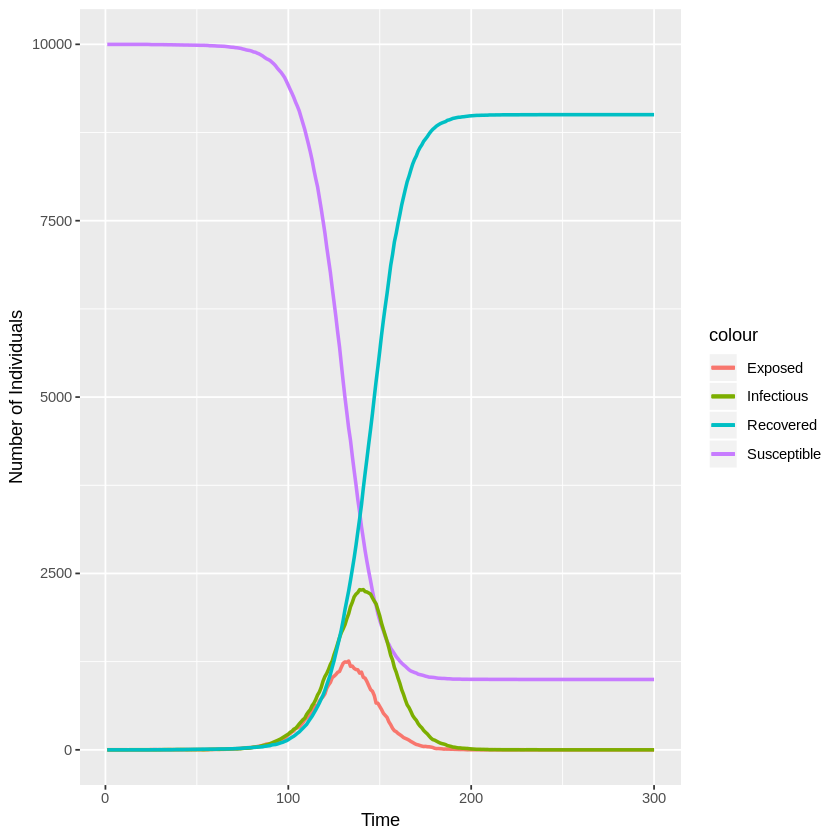

In [30]:
library(ggplot2)

ggplot(sim, aes(time)) + 
    geom_line(aes(y = S, colour = "Susceptible"), lwd = 1) + 
    geom_line(aes(y = E, colour = "Exposed"), lwd = 1) +
    geom_line(aes(y = I, colour = "Infectious"), lwd = 1) +
    geom_line(aes(y = R, colour = "Recovered"), lwd = 1) +
    xlab("Time") + ylab("Number of Individuals")

## Test Case

In [6]:
set.seed(12345)
test_sim <- seir_simulation( initial_state = c(S = 9999, E = 1, I = 0, R = 0),
                        parameters = c(5, 1, 10, 1, 0.25),
                        max_time = 100 )
test_result <- as.matrix( tail(test_sim, 3) )

correct_result <- matrix( c( 98, 7384, 794, 1015, 807,
                             99, 7184, 864, 1068, 884,
                            100, 6986, 920, 1144, 950), nrow = 3, byrow = T )

n_correct_cells <- sum(correct_result == test_result)
cat("\n--------------------\n")
if (n_correct_cells == 15) {
    cat("    Test PASSED\n")
} else {
    cat("    Test FAILED\n")
}
cat("--------------------\n\n")


-------------------
    Test PASSED
-------------------

